## Import Neccessary Libraries

In [2]:
import numpy as np
import tensorflow ,tensorflow.keras as keras
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from random import shuffle
from sklearn.metrics import confusion_matrix

In [3]:
#!unzip 'drive/My Drive/BrainLarge.zip' -d 'drive/My Drive/BrainLarge'

In [4]:
train_dir = r"combined/Training"
test_dir = r"combined/Testing"

## Data Preparation

### Data Labelling
Data images are divided into three classes respectively Meningioma,Pituitary and those with no tumor 

In [5]:
category = ["meningioma","notumor","pituitary"]
def naming(img):
    name = img.split(".")[0]
    if name == "notumor":
        return 0
    elif name == "pituitary":
        return 1
    elif name == "meningioma":
        return 2

### Image conversion 
This process involve the extraction of images from their respective array of pixels to for making it easy for the process of pre processing. OpenCV will be used for the extraction of multidimensinal pixels from the datasets

In [7]:
def clean(dir_):
  image = []
  for i in category:
    folder = os.path.join(dir_,i)
    for img in tqdm(os.listdir(folder)):
      path = os.path.join(folder,img)
      label = naming(img)
      img = cv2.imread(path)
      img = cv2.resize(img,(180,180))
      image.append([img,label])
  shuffle(image)
  return image

In [8]:
train = clean(train_dir)
test = clean(test_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:07<00:00, 37.14it/s]


In [9]:
data = train+test
shuffle(data)

Lets separate features and labels from the dataset to obtain the coresponding features and labels which will be fed to the model 

In [10]:
def extract(ls):
  X,y = [],[]
  for i,j in np.array(ls):
    X.append(i)
    y.append(j)
  X = np.array(X)
  y = np.array(y)
  X = X/255
  return X,y
X,y = extract(data)

Next step lets visualize some of the samples of the datasets to check the distribution of the datasets respectively

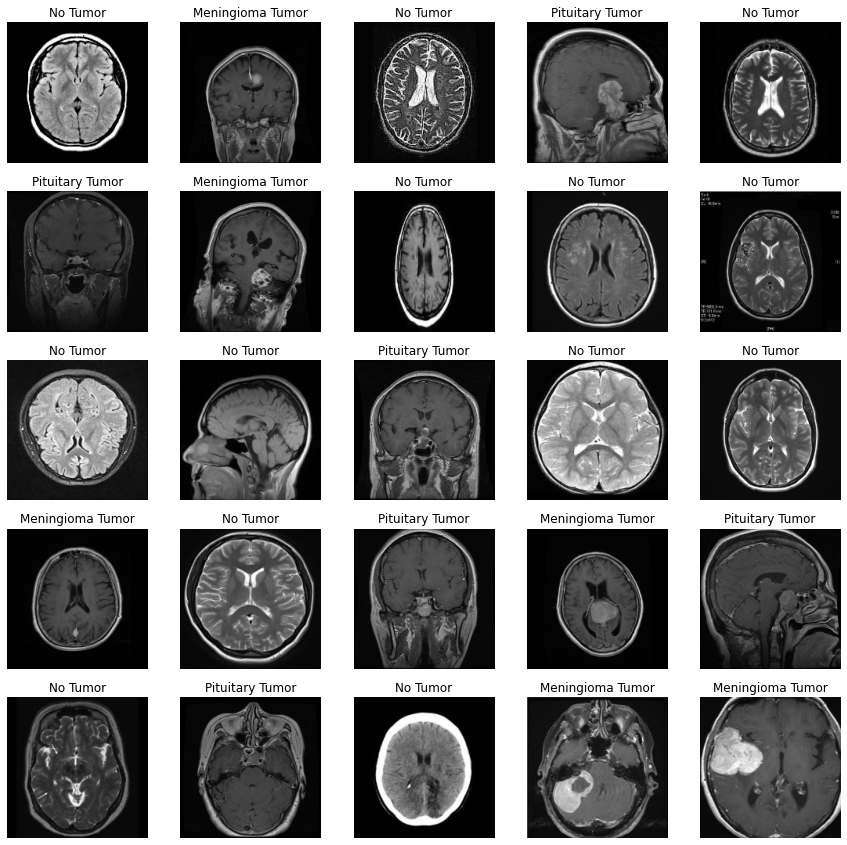

In [17]:
plt.figure(figsize=(15,15))
counter = 1
for i in range(25):
    plt.subplot(5,5,counter)
    plt.imshow(X[i])
    if y[i] == 0:
        plt.title("No Tumor")
    elif y[i] == 1:
        plt.title("Pituitary Tumor")
    elif y[i] == 2:
        plt.title("Meningioma Tumor")
    plt.axis("off")
    counter+= 1
plt.show()

lets check on the distribution of classes to check if there is any class imbalance and any other measures we can take to deal with imbalance respectively

<AxesSubplot:ylabel='count'>

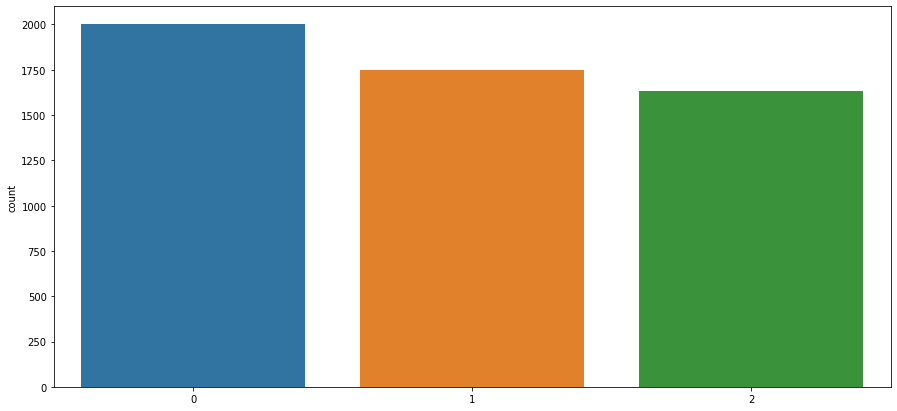

In [21]:
plt.figure(figsize=(15,7))
sns.countplot(y)

Well classes seems to be well distributed although the meningioma class seems to be with less number compare to others but its effects wont be to large extent

In [199]:
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# pre_trained = InceptionResNetV2(
#      weights='imagenet',
#      include_top=False, # Drop imagenet classifier on the top
#      input_shape=(120,120,3)
#  )
# for layer in pre_trained.layers:
#     layer.trainable = False

In [200]:
# inputs = keras.Input(shape=(120, 120, 3))
# x = pre_trained(inputs,training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.4)(x)
# output = keras.layers.Dense(4, activation='softmax')(x)
# model_base = keras.Model(inputs, output)

In [201]:
# model_base.compile(
#      optimizer="adam",
#      metrics=["accuracy"],
#      loss="sparse_categorical_crossentropy"
#  )

In [202]:
# history = model_base.fit(
#      x=X,
#      y=y,
#      epochs=50,
#      validation_split=0.2
#  )

In [203]:
#model_base.save("resnet1.h5")

In [204]:
# hist = pd.DataFrame(history.history)
# loss,val_loss,acc,val_acc = hist["loss"],hist["val_loss"],hist["accuracy"],hist["val_accuracy"]
# epoch = history.epoch
# plt.plot(epoch,loss,label="loss")
# plt.plot(epoch,val_loss,label="val_loss")
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

In [205]:
# epoch = history.epoch
# plt.plot(epoch,acc,label="acc")
# plt.plot(epoch,val_acc,label="val_acc")
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

### Splitting of Data 
Lets split the datasets to training and testing sets effectively to ratio of 80% for training and 20% for testing to maintaing the correct distribution

In [22]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(X,y,random_state=0,test_size=0.2)

## Model Building
Well for the case of the Model Buliding the Convolusion Neural Network will be our base model architecture for the task.We shall use the VGG3 block architecture which is made up with 3 convolusional base layers for the purpose of the feature extractions from the image arrays.Followed by one Flatten and three Dense network

In [55]:
from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Dropout,Flatten
from keras.callbacks import EarlyStopping
es = EarlyStopping()

model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(2,2),input_shape=(180,180,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(2,2),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(2,2),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=128,activation="relu"))
model.add(Dropout(rate=0.5))

model.add(Dense(units=64,activation="relu"))
model.add(Dropout(rate=0.3))

model.add(Dense(units=32,activation="relu"))
model.add(Dropout(rate=0.1))

model.add(Dense(units=3,activation="softmax"))

#### Model compliation

In [56]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#### Model Fitting

In [57]:
history = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=20)

Epoch 1/20
135/135 [==============================] - 7s 40ms/step - loss: 0.9569 - accuracy: 0.5100 - val_loss: 0.6032 - val_accuracy: 0.7676
Epoch 2/20
135/135 [==============================] - 5s 37ms/step - loss: 0.5833 - accuracy: 0.7875 - val_loss: 0.3872 - val_accuracy: 0.8583
Epoch 3/20
135/135 [==============================] - 5s 38ms/step - loss: 0.4454 - accuracy: 0.8431 - val_loss: 0.3382 - val_accuracy: 0.8843
Epoch 4/20
135/135 [==============================] - 5s 37ms/step - loss: 0.3663 - accuracy: 0.8758 - val_loss: 0.2777 - val_accuracy: 0.8963
Epoch 5/20
135/135 [==============================] - 5s 37ms/step - loss: 0.3142 - accuracy: 0.8895 - val_loss: 0.2928 - val_accuracy: 0.8954
Epoch 6/20
135/135 [==============================] - 5s 37ms/step - loss: 0.2641 - accuracy: 0.9085 - val_loss: 0.2024 - val_accuracy: 0.9296
Epoch 7/20
135/135 [==============================] - 5s 38ms/step - loss: 0.2189 - accuracy: 0.9245 - val_loss: 0.1754 - val_accuracy: 0.9389

#### Model Evaluation

In [24]:
accuracy,loss = model.evaluate(X_test,y_test)

Well from the observation the model scored with the accurcy of 96% which is not really bad but we can further evaluate the model with other parameters of evaluation such as confusion matrices

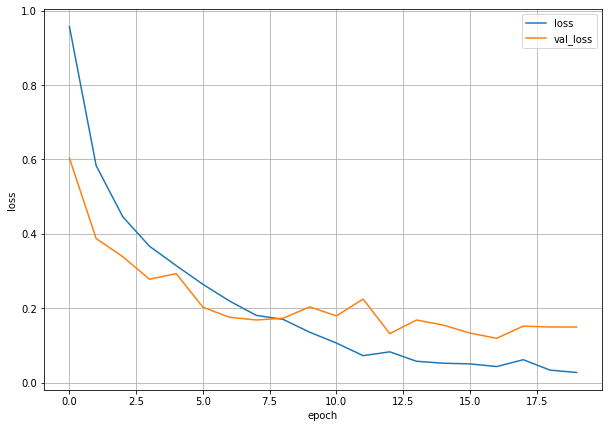

In [58]:
hist = pd.DataFrame(history.history)
loss,val_loss,acc,val_acc = hist["loss"],hist["val_loss"],hist["accuracy"],hist["val_accuracy"]
epoch = history.epoch
plt.figure(figsize=(10,7))
plt.plot(epoch,loss,label="loss")
plt.plot(epoch,val_loss,label="val_loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

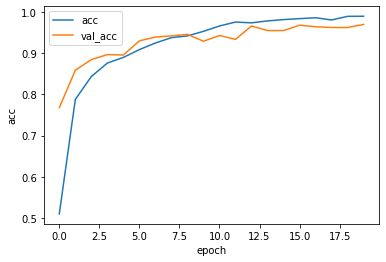

In [59]:
epoch = history.epoch
plt.plot(epoch,acc,label="acc")
plt.plot(epoch,val_acc,label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()

In [60]:
pr = model.predict(X_test)

In [61]:
pred = []
for i in pr:
    x = np.argmax(i)
    pred.append(x)
pred = np.array(pred)

Text(114.0, 0.5, 'Original')

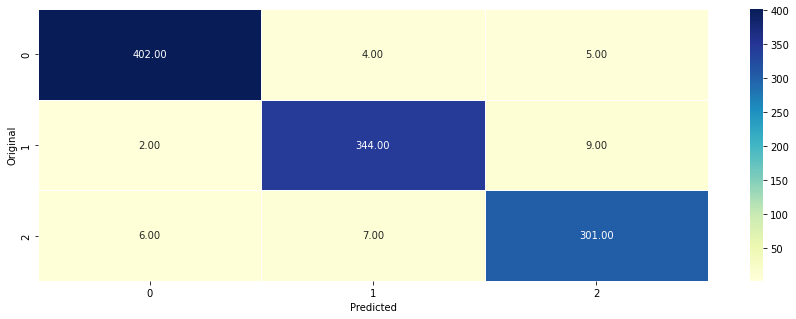

In [62]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(confusion_matrix(y_test,pred),
                annot=True,
                linewidths=0.5,
                fmt = '.2f',
                cmap='YlGnBu'
                )
plt.xlabel('Predicted')
plt.ylabel('Original')

In [63]:
model.save("model.h5")

#### Model Testing
Lets test the model other new datasets to check if it can respond well incase of the deployment to the production environment

In [64]:
def predict(model,image):
    image = f"C:/Users/Job Moshi/3D Objects/brain/combined/Testing/pituitary/pituitary.{image}.jpg"
    img = cv2.imread(image)
    image = keras.preprocessing.image.load_img(image,target_size=(30,30))
    image = keras.preprocessing.image.img_to_array(image)
    image = image/255
    image = tensorflow.expand_dims(image,0)
    pred = model.predict(image)
    pred = np.argmax(pred)
    if pred == 0:
          print("notumor")
          plt.imshow(img)
          plt.axis("off")
    if pred == 1:
         print("pituitay")
         plt.imshow(img)
         plt.axis("off")
    elif pred == 1:
         print("meningioma")
         plt.imshow(img)
         plt.axis("off")

pituitary


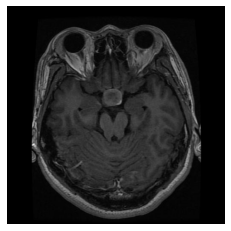

In [74]:
predict(model,10)

!!!Well gues what the model has responded well to the prediction and was able to predict the class of the Image with tumor respectively

Further improvement of the model can be done through
<ol>
<li><b>Data Augmentation</b></li>
<li><b>Pre trained model</b></li>
<li><b>Adjusting the parameters</b></li>
</ol>